# CNN Fish Classification
## Import Library

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, models
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix


## Importing the Fish image dataset and check the data

In [ ]:
dataset_path = '/content/drive/MyDrive/DEEPL/FishImgDataset'

In [ ]:
print("Isi folder dataset:")
folder_content = os.listdir(dataset_path)
print(folder_content)

Isi folder dataset:
['train', 'val', 'test']


In [ ]:
train_dir = os.path.join(dataset_path, 'train')
val_dir = os.path.join(dataset_path, 'val')
test_dir = os.path.join(dataset_path, 'test')

In [ ]:
print("\nIsi folder 'train':")
print(os.listdir(train_dir))

print("\nIsi folder 'val':")
print(os.listdir(val_dir))

print("\nIsi folder 'test':")
print(os.listdir(test_dir))


Isi folder 'train':
['Silver Perch', 'Scat Fish', 'Tenpounder', 'Pangasius', 'Snakehead', 'Silver Carp', 'Tilapia', 'Silver Barb', 'Perch', 'Indo-Pacific Tarpon', 'Knifefish', 'Mosquito Fish', 'Jaguar Gapote', 'Indian Carp', 'Green Spotted Puffer', 'Long-Snouted Pipefish', 'Mudfish', 'Mullet', 'Janitor Fish', 'Black Spotted Barb', 'Gold Fish', 'Glass Perchlet', 'Freshwater Eel', 'Catfish', 'Grass Carp', 'Goby', 'Fourfinger Threadfin', 'Gourami', 'Climbing Perch', 'Bangus', 'Big Head Carp']

Isi folder 'val':
['Tilapia', 'Snakehead', 'Tenpounder', 'Silver Carp', 'Pangasius', 'Silver Barb', 'Perch', 'Mullet', 'Silver Perch', 'Scat Fish', 'Long-Snouted Pipefish', 'Indo-Pacific Tarpon', 'Mudfish', 'Knifefish', 'Grass Carp', 'Janitor Fish', 'Indian Carp', 'Jaguar Gapote', 'Green Spotted Puffer', 'Mosquito Fish', 'Gold Fish', 'Black Spotted Barb', 'Gourami', 'Freshwater Eel', 'Fourfinger Threadfin', 'Goby', 'Big Head Carp', 'Glass Perchlet', 'Climbing Perch', 'Catfish', 'Bangus']

Isi folde

In [ ]:
def check_images_in_folder(folder_path):
    """Mendapatkan jumlah gambar dalam setiap subfolder (label) dan menyimpannya dalam DataFrame."""
    data = []
    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)
        if os.path.isdir(label_path):
            images = os.listdir(label_path)
            data.append([label, len(images)])
    return pd.DataFrame(data, columns=['Label', 'Image Count'])


In [ ]:
print("Memeriksa folder 'train'...")
train_df = check_images_in_folder(train_dir)
print(train_df)

print("\nMemeriksa folder 'val'...")
val_df = check_images_in_folder(val_dir)
print(val_df)

print("\nMemeriksa folder 'test'...")
test_df = check_images_in_folder(test_dir)
print(test_df)

Memeriksa folder 'train'...
                    Label  Image Count
0            Silver Perch          285
1               Scat Fish          154
2              Tenpounder          277
3               Pangasius          193
4               Snakehead          232
5             Silver Carp          238
6                 Tilapia          302
7             Silver Barb          329
8                   Perch          293
9     Indo-Pacific Tarpon          186
10              Knifefish          319
11          Mosquito Fish          256
12          Jaguar Gapote          229
13            Indian Carp          262
14   Green Spotted Puffer          110
15  Long-Snouted Pipefish          256
16                Mudfish          191
17                 Mullet          174
18           Janitor Fish          286
19     Black Spotted Barb          200
20              Gold Fish          206
21         Glass Perchlet          399
22         Freshwater Eel          273
23                Catfish          3

In [ ]:
def check_empty_folders(df, folder_name):
    """Memeriksa jika ada folder label yang kosong dan menampilkan peringatan"""
    empty_folders = df[df['Image Count'] == 0]
    if not empty_folders.empty:
        print(f"\nWarning: Ada folder kosong di '{folder_name}':")
        print(empty_folders[['Label', 'Image Count']])
check_empty_folders(train_df, 'train')
check_empty_folders(val_df, 'val')
check_empty_folders(test_df, 'test')

## Data Augmenting for Training Set

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

## Load image data and show it

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 8801 images belonging to 31 classes.
Found 2751 images belonging to 31 classes.
Found 1760 images belonging to 31 classes.


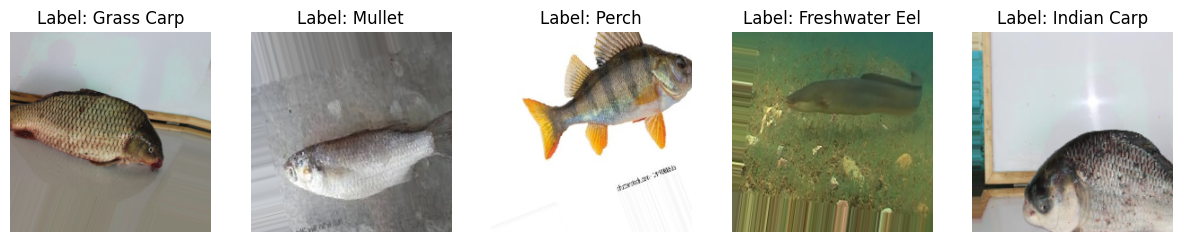

In [ ]:
def display_random_images(generator, num_images=5):
    """Menampilkan gambar acak dari generator."""
    images, labels = next(generator)
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {list(generator.class_indices.keys())[np.argmax(labels[i])]}")  # Menampilkan label gambar
        plt.axis('off')

    plt.show()

display_random_images(train_generator, num_images=5)


## Feature Engineering

In [ ]:
label_encoder = LabelEncoder()

In [ ]:
labels = os.listdir(train_dir)  # Daftar label (ikan) yang ada di train directory
label_encoder.fit(labels)

LabelEncoder()

In [ ]:
print("Informasi Dataset:")
print(f"Jumlah label: {len(labels)}")
print(f"Jumlah kelas: {len(label_encoder.classes_)}")

Informasi Dataset:
Jumlah label: 31
Jumlah kelas: 31


## CNN Model

In [ ]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(train_generator.num_classes, activation='softmax')  # Output layer dengan softmax
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Compile and Train Model

In [ ]:
model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=5,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
275/275 ━━━━━━━━━━━━━━━━━━━━ 8779s 32s/step - accuracy: 0.1519 - loss: 3.3489 - val_accuracy: 0.2493 - val_loss: 2.6683
Epoch 2/5
  1/275 ━━━━━━━━━━━━━━━━━━━━ 35:59 8s/step - accuracy: 0.1875 - loss: 3.0748

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


275/275 ━━━━━━━━━━━━━━━━━━━━ 122s 417ms/step - accuracy: 0.1875 - loss: 3.0748 - val_accuracy: 0.2419 - val_loss: 2.7004
Epoch 3/5
275/275 ━━━━━━━━━━━━━━━━━━━━ 1341s 5s/step - accuracy: 0.2237 - loss: 2.8251 - val_accuracy: 0.3239 - val_loss: 2.3323
Epoch 4/5
275/275 ━━━━━━━━━━━━━━━━━━━━ 103s 361ms/step - accuracy: 0.3750 - loss: 2.1036 - val_accuracy: 0.3261 - val_loss: 2.3327
Epoch 5/5
275/275 ━━━━━━━━━━━━━━━━━━━━ 1300s 5s/step - accuracy: 0.2953 - loss: 2.5245 - val_accuracy: 0.3662 - val_loss: 2.1890


## Evaluate the model

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

55/55 ━━━━━━━━━━━━━━━━━━━━ 1258s 23s/step - accuracy: 0.3528 - loss: 2.2595
Test Accuracy: 0.3648


In [ ]:
y_pred = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

55/55 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step


## Determine the evaluation metrics

In [ ]:
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')
roc_auc = roc_auc_score(y_true, y_pred, average='weighted', multi_class='ovr')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")

Accuracy: 0.0705
Precision: 0.0514
Recall: 0.0705
F1-Score: 0.0513
AUC-ROC: 0.5055


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Show the Confusion Matrix

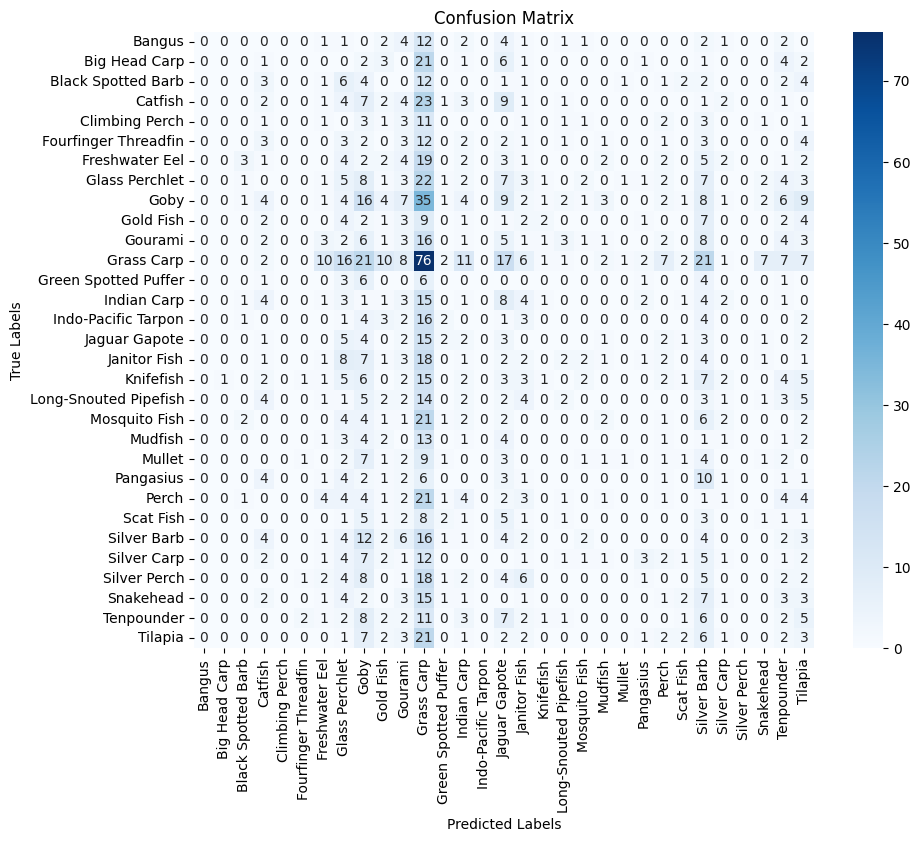

In [ ]:
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Show the model accuracy and model loss

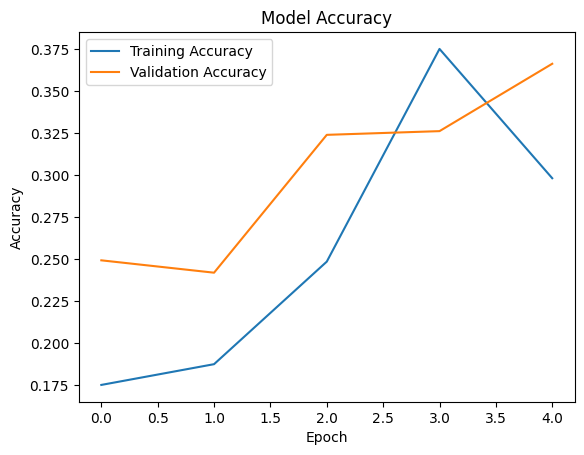

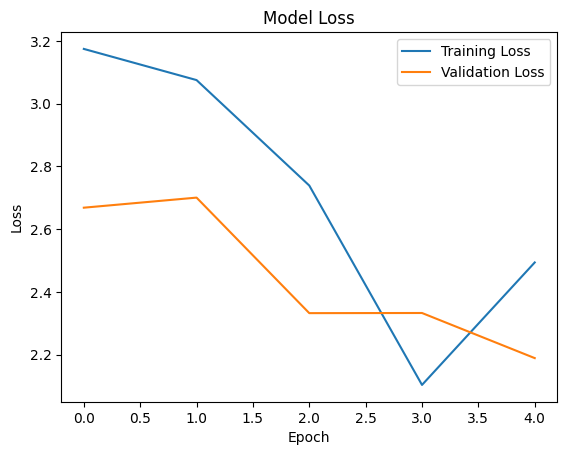

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()